In [275]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#!/usr/bin/env python
from __future__ import print_function

import argparse
import random
import numpy as np
from collections import deque

import json
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data Dictionary : Yellow Taxi Cab
- VendorID A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
- tpep_pickup_datetime The date and time when the meter was engaged.
- tpep_dropoff_datetime The date and time when the meter was disengaged.
- Passenger_count The number of passengers in the vehicle.
 This is a driver-entered value.
- Trip_distance The elapsed trip distance in miles reported by the taximeter.
- Pickup_longitude Longitude where the meter was engaged.
- Pickup_latitude Latitude where the meter was engaged.
- RateCodeID The final rate code in effect at the end of the trip.
 1= Standard rate 
 2=JFK
 3=Newark
 4=Nassau or Westchester
 5=Negotiated fare
 6=Group ride
- Store_and_fwd_flag This flag indicates whether the trip record was held in vehicle
 memory before sending to the vendor, aka “store and forward,”
 because the vehicle did not have a connection to the server.
- Y= store and forward trip
- N= not a store and forward trip
- Dropoff_longitude Longitude where the meter was disengaged.
- Dropoff_ latitude Latitude where the meter was disengaged.
- Payment_type A numeric code signifying how the passenger paid for the trip.
 1= Credit card
 2= Cash
 3= No charge
 4= Dispute
 5= Unknown
 6= Voided trip
- Fare_amount The time-and-distance fare calculated by the meter.
- Extra Miscellaneous extras and surcharges. Currently, this only includes
 t he 0.50 and 1 rush hour and overnight charges.
 M TA_tax 0.50 MTA tax that is automatically triggered based on the metered
 rate in use.
- Improvement_surcharge 0.30 improvement surcharge assessed trips at the flag drop. The
- improvement surcharge began being levied in 2015.
- Tip_amount Tip amount – This field is automatically populated for credit card
 tips. Cash tips are not included.
- Tolls_amount Total amount of all tolls paid in trip.
- Total_amount The total amount charged to passengers. Does not include cash tips.

### Geohash dictionary the distance between geohashes based on matching characters, in meters.
_PRECISION = {
    0: 20000000,
    1: 5003530,
    2: 625441,
    3: 123264,
    4: 19545,
    5: 3803,
    6: 610,
    7: 118,
    8: 19,
    9: 3.71,
    10: 0.6,
}

### Average speed of taxis
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [ ]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df = pd.read_csv("data/yellow_taxi_geohash_min_day.csv")

In [ ]:
# Encoding error
taxi_yellowcab_df['geohash_dropoff']=taxi_yellowcab_df['geohas_dropoff']

In [ ]:
taxi_lookup = pd.read_csv("data/taxi+_zone_lookup.csv")

In [ ]:
names_ = ['zipcode','city','state','lat','long','radius?','?']
#dataframe = read_csv('projects.csv', converters={'project_id': lambda x: str(x)})
zip_codes = pd.read_csv("data/zipcode.csv",converters={'zipcode': lambda x: str(x)},names=names_)

In [ ]:
zip_codes .head()

In [ ]:
taxi_lookup.head()

In [ ]:
zip_codes.info()

In [ ]:
# Truncate zip codes to only be NY

In [ ]:
zip_codes_ny = zip_codes[zip_codes.state=='NY']

In [11]:
zip_codes_ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2281 entries, 6 to 5721
Data columns (total 7 columns):
zipcode    2281 non-null object
city       2281 non-null object
state      2281 non-null object
lat        2281 non-null float64
long       2281 non-null float64
radius?    2281 non-null int64
?          2281 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 142.6+ KB


In [12]:
taxi_yellowcab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906858 entries, 0 to 10906857
Data columns (total 26 columns):
Unnamed: 0               int64
Unnamed: 0.1             int64
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
geohash_pickup           object
geohas_dropoff           object
jan_day                  int64
jan_minute               int64
geohash_dropoff          object
dtypes: float64(12), int64(8), object(6)
memory u

In [13]:
taxi_yellowcab_df.head(10)

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,...,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx,1,0,dr5rsx
1,1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,...,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk,1,0,dr5rtk
2,2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,...,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1,1,0,dr72j1
3,3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,...,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc,1,0,dr5rkc
4,4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,...,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue,1,0,dr5rue
5,5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,...,0.5,0.0,0.0,0.3,20.3,dr5ru9,dr5ryh,1,18,dr5ryh
6,6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,...,0.5,0.0,0.0,0.3,27.3,dr5rsh,dr72hc,1,26,dr72hc
7,7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,...,0.5,0.0,0.0,0.3,10.3,dr5ru9,dr5ru7,1,11,dr5ru7
8,8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,...,0.5,0.0,0.0,0.3,19.3,dr72j3,dr72mz,1,11,dr72mz
9,9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,...,0.5,0.0,0.0,0.3,12.8,dr5rsj,dr5rkp,1,11,dr5rkp


In [14]:
from datetime import datetime, timedelta, date
import dateutil
st_date = '2016-11-01'
dt = dateutil.parser.parse(st_date).date()
dt

datetime.date(2016, 11, 1)

## Create new columns for the day, minute, and month of january
- Don't run again, save this as csv

In [15]:
#taxi_yellowcab_df['jan_day']=[dateutil.parser.parse(i).day for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [16]:
#taxi_yellowcab_df['jan_minute']=[dateutil.parser.parse(i).minute for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [17]:
#taxi_yellowcab_df.to_csv("data/yellow_taxi_geohash_min_day.csv")

In [327]:
#taxi_yellowcab_df['month'] =[i.month for i in taxi_yellowcab_df.tpep_pickup_datetime]

In [329]:
#taxi_yellowcab_df['month'].unique()

array([1])

In [328]:
## filter to only have dates from January
#taxi_yellowcab_df[taxi_yellowcab_df['month']==2]

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,month


- Transform lat and long to zip code

>zip_code_data from: https://github.com/EverythingMe/geodis


### Create a geohash of the latitude and longtitude of the pickup and dropoff

In [123]:
def geohash_encoding(taxi_df,precision_=6):
    """Encode the latitude and longtitude of the pickup and dropoff into a geohash. For reference, the precision
    of a geohash depends on the number of characters present.
    _PRECISION = { 0: 20000000, 1: 5003530, 2: 625441, 3: 123264, 4: 19545,
    5: 3803, 6: 610, 7: 118, 8: 19, 9: 3.71, 10: 0.6, } - all distances in meters.
    
    Average taxi speed in 2014 was 5.51 miles per hour, or 3.8 meters per second.
    Precision of 5, means that a taxi should traverse this square in ~16 minutes.
    Precision of 6, means a taxi should traverse square in ~3 minutes.
    Precision of 7, means a taxi should traverse the square in ~1 minute.
    
    Input: Pandas DF
    Output: Pandas DF with geohas column appended"""
    now = time.time()
    new_taxidf = taxi_df.copy()
    geo_hash_pickup = []
    geo_hash_dropoff = []
    for row in new_taxidf.iterrows():
        # longittude followed by latitude
        pickup_vector = np.array( [row[1]['pickup_latitude'],row[1]['pickup_longitude']])
        dropoff_vector = np.array( [row[1]['dropoff_latitude'],row[1]['dropoff_longitude']])
        #geohash encoding
        geo_hash_pickup.append(gh.encode(pickup_vector[0],pickup_vector[1],precision=precision_))
        geo_hash_dropoff.append(gh.encode(dropoff_vector[0],dropoff_vector[1],precision=precision_))
    ## add in the new geohash columns
    new_taxidf['geohash_pickup'] = geo_hash_pickup
    new_taxidf['geohash_dropoff'] = geo_hash_dropoff 
    return new_taxidf
        
    
    

> Time how long this will take to run for 10 million rows
- 1k samples takes .297 seconds
- 10k samples takes 2.34 seconds
- 10 million rows is 1,000x 10k so 2340 seconds or 39 minutes

In [117]:
# Already ran this
#taxi_yellowcab_jan_geohash_df = geohash_encoding(taxi_yellowcab_df)

In [18]:
taxi_yellowcab_df .head()

,Unnamed: 0,Unnamed: 0.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff
0,0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,...,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx,1,0,dr5rsx
1,1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,...,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk,1,0,dr5rtk
2,2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,...,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1,1,0,dr72j1
3,3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,...,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc,1,0,dr5rkc
4,4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,...,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue,1,0,dr5rue


# Finding neighbors from a dropoff geohash
- use gh.neighbors

In [141]:
gh.neighbors(taxi_yellowcab_jan_geohash_df.geohas_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

## Heat map of the most profitable zip codes 

In [20]:
taxi_yellowcab_df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'geohash_pickup', 'geohas_dropoff', 'jan_day', 'jan_minute'],
      dtype='object')

In [333]:
## get a list of unique geohashes
unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(unique_geohashes)

3086

In [100]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [102]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [106]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [107]:
# can only plot 2k values on google maps

In [108]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

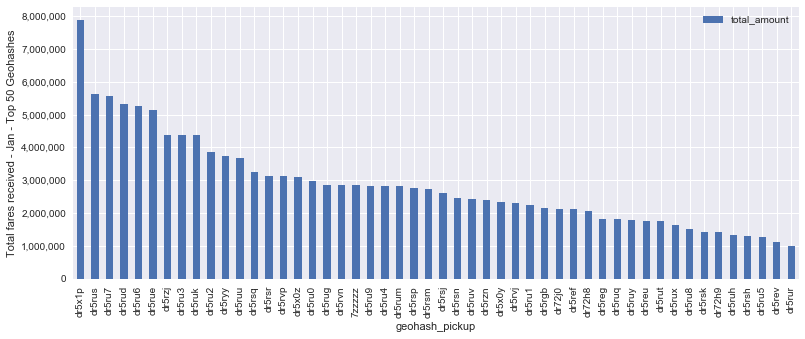

In [109]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

## Break up the day into five minute intervals( the time to traverse a geohash of ~610 meters).
- Average the time across the entire month of January

In [220]:
# Only pull the columns we need 
average_fare_during_day = taxi_yellowcab_df.loc[:,('tpep_pickup_datetime',
                            'tpep_dropoff_datetime','total_amount','geohash_dropoff','geohash_pickup')]

In [221]:
average_fare_during_day.tpep_pickup_datetime = pd.to_datetime(average_fare_during_day.tpep_pickup_datetime)


In [223]:
average_fare_during_day.index = average_fare_during_day.tpep_pickup_datetime


In [309]:
grouped_pickup_fares = average_fare_during_day.groupby(pd.TimeGrouper(freq='5Min')).apply(
    lambda x: x.groupby('geohash_pickup').mean())

In [310]:
grouped_pickup_fares  = grouped_pickup_fares.reset_index()

In [311]:
# groupby again only on minutes this time
grouped_pickup_fares['time'] = grouped_pickup_fares.tpep_pickup_datetime.apply(lambda x : x.time())

In [312]:
average_fares_throughout_day_geohash = grouped_pickup_fares.groupby(['time','geohash_pickup']).mean().reset_index()

In [331]:
average_fares_throughout_day_geohash['average_fare'] = average_fares_throughout_day_geohash['total_amount']
average_fares_throughout_day_geohash.drop('total_amount',inplace=True,axis=1)

In [334]:
# Turn this into a dictionary for fast lookups!

time_geohash_fare_dict = defaultdict(lambda : defaultdict(int))

In [337]:
for row in average_fares_throughout_day_geohash.iterrows():
    time_geohash_fare_dict[str(row[1]['time'])][row[1]['geohash_pickup']]=row[1]['average_fare']


In [338]:
time_geohash_fare_dict['09:20:00']['7zzzzz']

15.16335448753311

# Use an Actor Critic Model
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [75]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S

In [41]:
## Actor
HIDDEN1_UNITS=10
HIDDEN2_UNITS=20
state_size=5
print("Now we build the model")
S = Input(shape=[state_size])
h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)

Steering = Dense(1,activation='tanh')(h1)   
Acceleration = Dense(1,activation='sigmoid')(h1)   
Brake = Dense(1,activation='sigmoid')(h1)   
V = Concatenate([Steering,Acceleration,Brake])

model = Model(inputs=S,output=[Steering,Acceleration,Brake])
model.summary()
print("We finished building the model")


Now we build the model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 5)             0                                            
____________________________________________________________________________________________________
dense_75 (Dense)                 (None, 10)            60                                           
____________________________________________________________________________________________________
dense_76 (Dense)                 (None, 20)            220                                          
____________________________________________________________________________________________________
dense_77 (Dense)                 (None, 1)             21                                           
____________________________________________________________________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  '` call to the Keras 2 API: ' + signature)


In [50]:
## Critic
action_dim = 100
S = Input(shape=[state_size])
A = Input(shape=[action_dim],name='action2')    
w1 = Dense(HIDDEN1_UNITS, activation='relu')(S)
a1 = Dense(HIDDEN2_UNITS, activation='linear')(A)
h1 = Dense(HIDDEN2_UNITS, activation='linear')(w1)
h2 = Add(h1,a1)    
h3 = Dense(HIDDEN2_UNITS, activation='relu')(h2)
V = Dense(action_dim,activation='linear')(h3) 

model = Concatenate(input=[S,A],output=V)

adam = Adam(lr=self.LEARNING_RATE)
model.compile(loss='mse', optimizer=adam)
print("We finished building the model")

TypeError: __init__() takes 1 positional argument but 3 were given

In [56]:
##Define a simple model where the output is a softmax probability over the eight states
# INputs will be the time, current geohash
model_simple = Sequential()
model_simple.add(Dense(100, activation='relu', input_shape= (2,)))
model_simple.add(Dense(9, activation='softmax')) ## predict which geohash to move to next
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_98 (Dense)             (None, 8)                 808       
Total params: 1,108.0
Trainable params: 1,108
Non-trainable params: 0.0
_________________________________________________________________


In [ ]:
# parameters
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 9 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 3200. # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4

In [ ]:
def trainNetwork(model,args):
    # open up a game state to communicate with emulator
    game_state = game.GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(80,80))
    x_t = skimage.exposure.rescale_intensity(x_t,out_range=(0,255))

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    #print (s_t.shape)

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4

    
    if args['mode'] == 'Run':
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON

    t = 0
    while (True):
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1

        #We reduced the epsilon gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        #run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1,(80,80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))

        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE:
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)



            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 80, 80, 4
            print (inputs.shape)
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                terminal = minibatch[i][4]
                # if terminated, only equals reward

                inputs[i:i + 1] = state_t    #I saved down s_t

                targets[i] = model.predict(state_t)  # Hitting each buttom probability
                Q_sa = model.predict(state_t1)

                if terminal:
                    targets[i, action_t] = reward_t
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)

        s_t = s_t1
        t = t + 1

        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            model.save_weights("model.h5", overwrite=True)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")